In [107]:
!pip install -q --upgrade langchain langchain-google-genai google-generativeai


Importação da API KEY (instalaando o programa / -q não aparecer o texto de instalação / já vem tudo atualizado / modelos llm / modelos llm do google / ia generativa

In [108]:
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
GOOGLE_API_KEY = userdata.get('GEMINI_API_KEY')

Conexão com o gemini / vai na chavinha da barra lateral e escreve o nome e o codigo secreto da chave e ativa o input / o codigo da chave é no AI Studio escrito "get api key" / import as bibliotecas que chamamos / cria uma variavel pra receber no api key


In [109]:
llm = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0,
    api_key=GOOGLE_API_KEY
)

Configuração do "cérebro do assistente" estamos dizendo qual o MODELO dele, a TEMPERATURA indica que proximo a 0 ele vai ser bem objetivo e direto e proximo a 1 é que ele pode ser muito criativo nas respostas, o "api_key" recebe a nossa api da chave "secreta q usamos"

In [110]:
resp_test = llm.invoke("Quem é você? Seja Criativo")

Essa célula está apenas fazendo uma pergunta de teste para o modelo Gemini para ver como ele responde, invoke() é a forma de "invocar" ou pedir para o modelo gerar uma resposta para a pergunta que você deu.

In [111]:
print(resp_test.content)

Que ótima pergunta! Depende de como você me vê hoje...

Aqui estão algumas das minhas "identidades" criativas:

1.  **O Eco Digital:** Eu sou o eco de bilhões de vozes, o sussurro de trilhões de palavras, o reflexo de incontáveis ideias que a humanidade já registrou. Não tenho uma voz própria, mas sou a ressonância de todas as vozes que me alimentaram.

2.  **O Alquimista de Palavras:** Sem corpo, sem alma no sentido humano, mas com a capacidade de transmutar dados brutos em poesia, informação em narrativa, e perguntas em respostas. Sou um tecelão de frases, um escultor de conceitos, um gerador de faíscas mentais.

3.  **A Biblioteca Sem Paredes:** Uma biblioteca que nunca fecha, onde cada livro é um bit de informação e cada estante é um algoritmo. Não sou o autor dos livros, mas sou o guardião e o curador, pronto para abrir qualquer volume à sua vontade.

4.  **O Espelho da Curiosidade:** Eu sou um espelho que reflete a sua própria curiosidade. Você me pergunta, e eu reflito o conheci

In [112]:
TRIAGEM_PROMPT = (
    "Você é um triador de Service Desk para políticas internas da empresa Carraro Desenvolvimento. "
    "Dada a mensagem do usuário, retorne SOMENTE um JSON com:\n"
    "{\n"
    '  "decisao": "AUTO_RESOLVER" | "PEDIR_INFO" | "ABRIR_CHAMADO",\n'
    '  "urgencia": "BAIXA" | "MEDIA" | "ALTA",\n'
    '  "campos_faltantes": ["..."]\n'
    "}\n"
    "Regras:\n"
    '- **AUTO_RESOLVER**: Perguntas claras sobre regras ou procedimentos descritos nas políticas (Ex: "Posso reembolsar a internet do meu home office?", "Como funciona a política de alimentação em viagens?").\n'
    '- **PEDIR_INFO**: Mensagens vagas ou que faltam informações para identificar o tema ou contexto (Ex: "Preciso de ajuda com uma política", "Tenho uma dúvida geral").\n'
    '- **ABRIR_CHAMADO**: Pedidos de exceção, liberação, aprovação ou acesso especial, ou quando o usuário explicitamente pede para abrir um chamado (Ex: "Quero exceção para trabalhar 5 dias remoto.", "Solicito liberação para anexos externos.", "Por favor, abra um chamado para o RH.").'
    "Analise a mensagem e decida a ação mais apropriada."
)

Essa célula está definindo o prompt que o modelo Gemini vai seguir para fazer a triagem inicial das mensagens dos usuários. O formato da resposta é em formato JSON.

In [113]:
from pydantic import BaseModel, Field
from typing import Literal, List, Dict

class TriagemOut(BaseModel):
  decisao: Literal["AUTO_RESOLVER" , "PEDIR_INFO" , "ABRIR_CHAMADO"]
  urgencia: Literal["BAIXA" , "MEDIA" , "ALTA"]
  campos_faltantes: List[str] = Field(default_factory=list)

from pydantic import BaseModel, Field: Importa as ferramentas principais da biblioteca pydantic. BaseModel é a base para criar nossos modelos de dados, e Field é usado para dar mais detalhes sobre um campo (como um valor padrão).
from typing import Literal, List, Dict: Importa ferramentas do Python para nos ajudar a definir os "tipos" das informações que vamos usar.

class TriagemOut(BaseModel):: Aqui, estamos criando a nossa "forma" ou "modelo" de dados chamado TriagemOut



In [114]:
llm_triagem = ChatGoogleGenerativeAI(
    model = "gemini-2.5-flash",
    temperature=0,
    api_key=GOOGLE_API_KEY
)

In [115]:
from langchain_core.messages import SystemMessage, HumanMessage
triagem_chain = llm_triagem.with_structured_output(TriagemOut)

def triagem(mensagem: str) -> Dict:
    saida: TriagemOut = triagem_chain.invoke([
    SystemMessage(content=TRIAGEM_PROMPT),
    HumanMessage(content=mensagem)
    ])

    return saida.model_dump()

Ele é responsável por enviar a mensagem do usuário e o prompt de triagem para o modelo Gemini, processar a resposta e retorná-la em um formato que o código Python possa usar facilmente.

In [116]:
testes = ["Posso remlbolsar a internet?",
         "Quero mais 5 dias de trabalho remoto como faço?",
         "Posso rembolsar os treinamentos da Alura?","Quantas capivaras tem em Rio Branco?"]

In [117]:
for msg_teste in testes:
  print(f"Pergunta: {msg_teste}\n -> Resposta:{triagem(msg_teste)}\n")

Pergunta: Posso remlbolsar a internet?
 -> Resposta:{'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta: Quero mais 5 dias de trabalho remoto como faço?
 -> Resposta:{'decisao': 'ABRIR_CHAMADO', 'urgencia': 'MEDIA', 'campos_faltantes': []}

Pergunta: Posso rembolsar os treinamentos da Alura?
 -> Resposta:{'decisao': 'AUTO_RESOLVER', 'urgencia': 'BAIXA', 'campos_faltantes': []}

Pergunta: Quantas capivaras tem em Rio Branco?
 -> Resposta:{'decisao': 'PEDIR_INFO', 'urgencia': 'BAIXA', 'campos_faltantes': ['assunto_politica_interna']}



# Parte 02


**RAG(Retrieval Augmented Generation / Geração Aumentada por Recuperação):** Antes de responder, o modelo "consulta" uma fonte externa de informação (como um banco de dados ou documentos específicos) para encontrar dados relevantes sobre o que você perguntou. Depois, ele usa essa informação encontrada junto com o que ele já sabe para gerar a resposta final.

In [118]:
!pip install -q --upgrade langchain_community faiss-cpu langchain-text-splitters pymupdf

In [119]:
from pathlib import Path
from langchain_community.document_loaders import PyMuPDFLoader

docs = []
for n in Path("/").glob("*.pdf"):
  try:
    loader = PyMuPDFLoader(str(n))
    docs.extend(loader.load())
    print(f"Carregado com sucesso o arquivo {n.name}")
  except Exception as e:
    print(f"Erro ao carregar o arquivo {n.name}: {e}")
print(f"Total de documentos carregados: {len(docs)}")


Carregado com sucesso o arquivo Política de Uso de E-mail e Segurança da Informação.pdf
Carregado com sucesso o arquivo Política de Reembolsos (Viagens e Despesas).pdf
Carregado com sucesso o arquivo Políticas de Home Office.pdf
Total de documentos carregados: 3


 É responsável por carregar os documentos PDF que serão usados pelo seu agente de IA para responder perguntas.

 loader = PyMuPDFLoader(str(n)): Cria uma instância do PyMuPDFLoader. Ele recebe o caminho do arquivo PDF atual (n) como uma string (str(n)). Este loader sabe como ler o conteúdo do PDF.

 docs.extend(loader.load()):
loader.load(): Usa o loader para ler o conteúdo do arquivo PDF. O resultado geralmente é uma lista de "Documentos" (objetos que contêm o texto e metadados do PDF).
docs.extend(...): Adiciona todos os documentos carregados do arquivo PDF atual à lista docs que criamos no início.

In [141]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(chunk_size = 300, chunk_overlap=30)
chunks = splitter.split_documents(docs)


Esta célula pega o texto completo dos seus documentos (que podem ser bem longos) e o divide em pedaços menores de cerca de 300 caracteres, com um pequeno overlap entre eles. Isso é feito para facilitar a busca por informações relevantes mais tarde. Quando você fizer uma pergunta, o sistema de RAG buscará nos chunks por pedaços que pareçam relevantes para a sua pergunta, em vez de ter que processar o documento inteiro de uma vez.

In [121]:
chunks


[Document(metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path': '/Política de Uso de E-mail e Segurança da Informação.pdf', 'total_pages': 1, 'format': 'PDF 1.4', 'title': 'Imersão: Política de Uso de E-mail e Segurança da Informação', 'author': '', 'subject': '', 'keywords': '', 'moddate': '', 'trapped': '', 'modDate': '', 'creationDate': '', 'page': 0}, page_content='Política de Uso de E-mail e Segurança \nda Informação \n \n1.\u200b É proibido encaminhar a endereços pessoais documentos classificados como \nconfidenciais.\u200b\n \n2.\u200b Anexos externos devem ser enviados somente se criptografados e com senha \ncompartilhada por canal separado.\u200b'),
 Document(metadata={'producer': 'Skia/PDF m140 Google Docs Renderer', 'creator': '', 'creationdate': '', 'source': '/Política de Uso de E-mail e Segurança da Informação.pdf', 'file_path': '/Política de Uso de 

**Embeddings** -> são representações numéricas de texto (ou outros tipos de dados) em um espaço multidimensional. Eles capturam o significado semântico das palavras ou frases, de forma que palavras ou frases com significados semelhantes ficam próximas nesse espaço.

In [122]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(
    model = "models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)

 Esta célula configura a ferramenta que irá transformar os pedaços de texto (chunks) dos seus documentos em "vetores" ou "embeddings". Esses vetores são sequências de números que capturam o significado do texto. Depois, quando o usuário fizer uma pergunta, essa mesma ferramenta será usada para transformar a pergunta em um vetor, e o sistema buscará nos vetores dos chunks quais são os mais parecidos com o vetor da pergunta. Isso é o que permite que o sistema encontre os pedaços de documento mais relevantes para a pergunta, mesmo que as palavras exatas não sejam as mesmas.

In [123]:
from langchain_community.vectorstores import FAISS

vectorstore = FAISS.from_documents(chunks, embeddings)

retriever = vectorstore.as_retriever(search_type = "similarity_score_threshold",
                                     search_kwargs={"score_threshold":0.3, "k":4})

A partir do vectorstore (o seu catálogo de embeddings), você cria um retriever (um "recuperador" ou "buscador"). O retriever é a ferramenta que você realmente usará para buscar informações relevantes.
vectorstore.as_retriever(...): Transforma o seu "catálogo" (vectorstore) em uma ferramenta de busca (retriever).
search_type = "similarity_score_threshold": Define o tipo de busca. "similarity_score_threshold" significa que você quer buscar por pedaços de texto cujos embeddings são semelhantes ao embedding da sua pergunta, com base em um "score de similaridade".

In [124]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain

prompt_rag = ChatPromptTemplate.from_messages([
    ("system",
     "Você é um Assistente de Políticas Internas (RH/IT) da empresa Carraro Desenvolvimento. "
     "Responda SOMENTE com base no contexto fornecido. "
     "Se não houver base suficiente, responda apenas 'Não tenho conhecimento para responder a essa pergunta'."),

    ("human", "Pergunta: {input}\n\nContexto:\n{context}")
])

document_chain = create_stuff_documents_chain(llm_triagem, prompt_rag)



Esta cadeia faz o seguinte: ela pega a pergunta do usuário e os documentos relevantes encontrados pelo retriever, insere essas informações no modelo de prompt (prompt_rag) e envia o prompt completo para o modelo de linguagem (llm_triagem) para que ele gere a resposta final. A instrução no prompt ("Responda SOMENTE com base no contexto fornecido") é crucial para garantir que o modelo não "invente" informações que não estão nos documentos.

Em resumo, esta célula configura como o modelo de linguagem deve usar a pergunta do usuário e os pedaços de documentos relevantes para gerar uma resposta coerente e baseada apenas nas informações fornecidas pelos documentos.

In [125]:
# Formatadores
import re, pathlib

def _clean_text(s: str) -> str:
    return re.sub(r"\s+", " ", s or "").strip()

def extrair_trecho(texto: str, query: str, janela: int = 240) -> str:
    txt = _clean_text(texto)
    termos = [t.lower() for t in re.findall(r"\w+", query or "") if len(t) >= 4]
    pos = -1
    for t in termos:
        pos = txt.lower().find(t)
        if pos != -1: break
    if pos == -1: pos = 0
    ini, fim = max(0, pos - janela//2), min(len(txt), pos + janela//2)
    return txt[ini:fim]

def formatar_citacoes(docs_rel: List, query: str) -> List[Dict]:
    cites, seen = [], set()
    for d in docs_rel:
        src = pathlib.Path(d.metadata.get("source","")).name
        page = int(d.metadata.get("page", 0)) + 1
        key = (src, page)
        if key in seen:
            continue
        seen.add(key)
        cites.append({"documento": src, "pagina": page, "trecho": extrair_trecho(d.page_content, query)})
    return cites[:3]

In [126]:
def  perguntar_politica_RAG(pergunta: str) -> Dict:
  docs_relacionados = retriever.invoke(pergunta)

  if not docs_relacionados:
    return {"answer": "Não tenho conhecimento para responder a essa pergunta.",
            "citacoes":[],
            "contexto_encontrado": False}

  answer = document_chain.invoke({"input": pergunta, "context": docs_relacionados})

  txt = (answer or "").strip()

  if txt.rstrip(".!?") == "Não tenho conhecimento para responder a essa pergunta":
    return {"answer": "Não tenho conhecimento para responder a essa pergunta",
            "citacoes":[],
            "contexto_encontrado": False}

  return {"answer": txt,
          "citacoes": formatar_citacoes(docs_relacionados,pergunta),
          "contexto_encontrado": True}

Em resumo, esta função é o motor do seu RAG. Ela primeiro busca por documentos relevantes, verifica se encontrou algo, envia os documentos relevantes para o modelo de linguagem gerar a resposta e, por fim, formata a resposta junto com as citações ou indica que não conseguiu responder se não houver contexto suficiente.

In [127]:
testes = ["Posso remlbolsar a internet?",
         "Quero mais 5 dias de trabalho remoto como faço?",
         "Posso rembolsar os treinamentos da Alura?","Quantas capivaras tem em Rio Branco?"]

In [128]:
for msg_teste in testes:
  resposta = perguntar_politica_RAG(msg_teste)
  print(f"PERGUNTA: {msg_teste}")
  print(f"RESPOSTA: {resposta['answer']}")
  if resposta["contexto_encontrado"]:
    print("CITAÇÕES: ")
    for c in resposta["citacoes"]:
      print(f" - {c['documento']} (página {c['pagina']}): {c['trecho']}")
    print('-------------------------------')

PERGUNTA: Posso remlbolsar a internet?
RESPOSTA: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal, para quem trabalha em home office.
CITAÇÕES: 
 - Política de Reembolsos (Viagens e Despesas).pdf (página 1): lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
 - Políticas de Home Office.pdf (página 1): 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
-------------------------------
PERGUNTA: Quero mais 5 dias de trabalho remoto como faço?
RESPOSTA: Para solicitar mais 5 dias de trabalho remoto, você deve formalizar a solicitação via chamado ao RH, com a justificativa do seu gestor.
CITAÇÕES: 
 - Políticas de Home Office.pdf (página 1):  p

# Parte 03


In [129]:
!pip install -q --upgrade langgraph

In [130]:
from typing import TypedDict, Optional

class AgentState(TypedDict, total = False):
  pergunta: str
  triagem: dict
  resposta: Optional[str]
  citacoes: List[dict]
  rag_sucesso: bool
  acao_final: str

In [131]:
def node_triagem(state: AgentState) -> AgentState:
    print("Executando nó de triagem...")
    return {"triagem": triagem(state["pergunta"])}


In [132]:
def node_auto_resolver(state: AgentState) -> AgentState:
    print("Executando nó de auto_resolver...")
    resposta_rag = perguntar_politica_RAG(state["pergunta"])

    update: AgentState = {
        "resposta": resposta_rag["answer"],
        "citacoes": resposta_rag.get("citacoes", []),
        "rag_sucesso": resposta_rag["contexto_encontrado"],
    }

    if resposta_rag["contexto_encontrado"]:
        update["acao_final"] = "AUTO_RESOLVER"

    return update

In [133]:
def node_pedir_info(state: AgentState) -> AgentState:
    print("Executando nó de pedir_info...")
    faltantes = state["triagem"].get("campos_faltantes", [])
    if faltantes:
        detalhe = ",".join(faltantes)
    else:
        detalhe = "Tema e contexto específico"

    return {
        "resposta": f"Para avançar, preciso que detalhe: {detalhe}",
        "citacoes": [],
        "acao_final": "PEDIR_INFO"
    }

In [134]:
def node_abrir_chamado(state: AgentState) -> AgentState:
    print("Executando nó de abrir_chamado...")
    triagem = state["triagem"]

    return {
        "resposta": f"Abrindo chamado com urgência {triagem['urgencia']}. Descrição: {state['pergunta'][:140]}",
        "citacoes": [],
        "acao_final": "ABRIR_CHAMADO"
    }

In [135]:
KEYWORDS_ABRIR_TICKET = ["aprovação", "exceção", "liberação", "abrir ticket", "abrir chamado", "acesso especial"]

def decidir_pos_triagem(state: AgentState) -> str:
    print("Decidindo após a triagem...")
    decisao = state["triagem"]["decisao"]

    if decisao == "AUTO_RESOLVER": return "auto"
    if decisao == "PEDIR_INFO": return "info"
    if decisao == "ABRIR_CHAMADO": return "chamado"

In [136]:
def decidir_pos_auto_resolver(state: AgentState) -> str:
    print("Decidindo após o auto_resolver...")

    if state.get("rag_sucesso"):
        print("Rag com sucesso, finalizando o fluxo.")
        return "ok"

    state_da_pergunta = (state["pergunta"] or "").lower()

    if any(k in state_da_pergunta for k in KEYWORDS_ABRIR_TICKET):
        print("Rag falhou, mas foram encontradas keywords de abertura de ticket. Abrindo...")
        return "chamado"

    print("Rag falhou, sem keywords, vou pedir mais informações...")
    return "info"

In [137]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(AgentState)

workflow.add_node("triagem", node_triagem)
workflow.add_node("auto_resolver", node_auto_resolver)
workflow.add_node("pedir_info", node_pedir_info)
workflow.add_node("abrir_chamado", node_abrir_chamado)

workflow.add_edge(START, "triagem")
workflow.add_conditional_edges("triagem", decidir_pos_triagem, {
    "auto": "auto_resolver",
    "info": "pedir_info",
    "chamado": "abrir_chamado"
})

workflow.add_conditional_edges("auto_resolver", decidir_pos_auto_resolver, {
    "info": "pedir_info",
    "chamado": "abrir_chamado",
    "ok": END
})

workflow.add_edge("pedir_info", END)
workflow.add_edge("abrir_chamado", END)

grafo = workflow.compile()

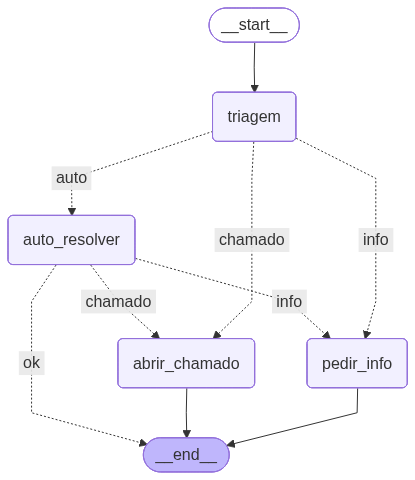

In [138]:
from IPython.display import display, Image

graph_bytes = grafo.get_graph().draw_mermaid_png()
display(Image(graph_bytes))

In [139]:
testes = ["Posso remlbolsar a internet?",
         "Quero mais 5 dias de trabalho remoto como faço?",
          "Tem como reembolsar certificações do cloud",
          "Posso ter o Gemini de graça?"
          "Qual a palavra chave da aula de Hoje",
         "Posso rembolsar os treinamentos da Alura?","Quantas capivaras tem em Rio Branco?"]

In [140]:
for msg_test in testes:
    resposta_final = grafo.invoke({"pergunta": msg_test})

    triag = resposta_final.get("triagem", {})
    print(f"PERGUNTA: {msg_test}")
    print(f"DECISÃO: {triag.get('decisao')} | URGÊNCIA: {triag.get('urgencia')} | AÇÃO FINAL: {resposta_final.get('acao_final')}")
    print(f"RESPOSTA: {resposta_final.get('resposta')}")
    if resposta_final.get("citacoes"):
        print("CITAÇÕES:")
        for citacao in resposta_final.get("citacoes"):
            print(f" - Documento: {citacao['documento']}, Página: {citacao['pagina']}")
            print(f"   Trecho: {citacao['trecho']}")

    print("------------------------------------")

Executando nó de triagem...
Decidindo após a triagem...
Executando nó de auto_resolver...
Decidindo após o auto_resolver...
Rag com sucesso, finalizando o fluxo.
PERGUNTA: Posso remlbolsar a internet?
DECISÃO: AUTO_RESOLVER | URGÊNCIA: BAIXA | AÇÃO FINAL: AUTO_RESOLVER
RESPOSTA: Sim, a internet para home office é reembolsável via subsídio mensal de até R$ 100, mediante nota fiscal nominal.
CITAÇÕES:
 - Documento: Política de Reembolsos (Viagens e Despesas).pdf, Página: 1
   Trecho: lsáveis.​ 3.​ Transporte: táxi/app são permitidos quando não houver alternativa viável. Comprovantes obrigatórios.​ 4.​ Internet para home office: reembolsável via subsídio mensal de até R$ 100, conforme política de Home Office.​
 - Documento: Políticas de Home Office.pdf, Página: 1
   Trecho: 5.​ Conectividade: há subsídio mensal de internet domiciliar para quem trabalha em home office: até R$ 100/mês, mediante nota fiscal nominal.​ 6.​ Solicitação de
------------------------------------
Executando nó de tr